<a href="https://colab.research.google.com/github/lollcat/fab-torch/blob/master/demo/aldp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alanine dipeptide: Using the model trained with FAB including a replay buffer

In [1]:
# Installs

In [2]:
# Import packages
import urllib

import torch
import numpy as np
import mdtraj

from tqdm import tqdm
from matplotlib import pyplot as plt

from fab.utils.training import load_config
from experiments.make_flow.make_aldp_model import make_aldp_model

from openmmtools.testsystems import AlanineDipeptideVacuum

In [3]:
# Set precision
torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Download config from Hugging Face
urllib.request.urlretrieve('https://huggingface.co/VincentStimper/fab/resolve/main/aldp/config.yaml', 'config.yaml')

('config.yaml', <http.client.HTTPMessage at 0x7f6359ef4c50>)

In [5]:
# Load config and adapt path to 
config = load_config('config.yaml')

config['data']['transform'] = '../' + config['data']['transform']

In [6]:
# Create model from config
model = make_aldp_model(config, device)

In [7]:
# Download model from Hugging Face
urllib.request.urlretrieve('https://huggingface.co/VincentStimper/fab/resolve/main/aldp/model.pt', 'model.pt')

('model.pt', <http.client.HTTPMessage at 0x7f6359aeb150>)

In [8]:
# Load model weights
model.load('model.pt', map_location=device)

In [9]:
# Generate model samples
batch_size = 100
n_batches = 1000

x_list = []

with torch.no_grad():
    for _ in tqdm(range(n_batches)):
        # Generate samples in internal coordinates
        z = model.flow.sample((batch_size,))
        # Transform samples to Cartesian coordinates
        x, _ = model.target_distribution.coordinate_transform(z)
        x_list.append(x.cpu().numpy())

x = np.concatenate(x_list)

100%|██████████| 1000/1000 [01:55<00:00,  8.65it/s]


In [10]:
# Get dihedral angles phi and psi for Ramachandran plot
aldp = AlanineDipeptideVacuum()
topology = mdtraj.Topology.from_openmm(aldp.topology)
traj = mdtraj.Trajectory(x.reshape(-1, 22, 3), topology)

phi = mdtraj.compute_phi(traj)[1].reshape(-1)
psi = mdtraj.compute_psi(traj)[1].reshape(-1)

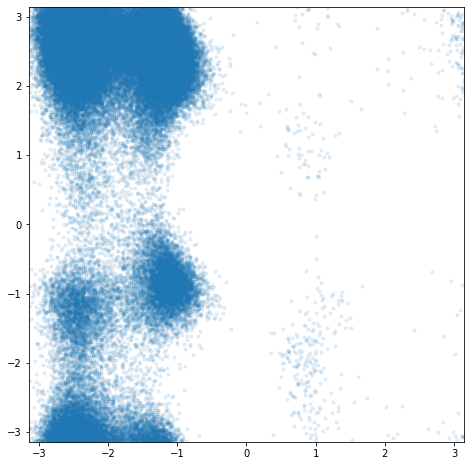

In [11]:
# Ramachandran plot
plt.figure(figsize=(8, 8))
plt.plot(phi, psi, '.', alpha=0.1)
plt.xlim([-np.pi, np.pi])
plt.ylim([-np.pi, np.pi])
plt.gca().set_box_aspect(1)
plt.show()